In [1]:
import GraphMatching

┌ Info: Precompiling GraphMatching [9e22f0a7-b05b-4b44-b659-080a67e9ff0f]
└ @ Base loading.jl:1317


In [2]:
using ProgressMeter
using Statistics
using DataFrames
using CSV
using Dates

In [3]:
using Plots
plotly();

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /Users/flixpar/.julia/packages/Plots/iYDwd/src/backends.jl:372


In [4]:
ENV["COLUMNS"] = 1000;

In [5]:
n1 = 100;
n2 = 200;
n = n1 + n2;

In [6]:
m = 50;

In [7]:
p_step = 0.05;
q_step = 0.05;

In [8]:
ps = p_step:p_step:(1-p_step);
qs = q_step:q_step:(1-q_step);

In [9]:
μ = 0.4;

In [10]:
ρes = [0.0];

In [11]:
iterations = 2;

In [12]:
function block_match_ratio(true_match::Array{Int,2}, est_match::Array{Int,2}, b::Array{Int,1}, m::Int=0)
    true_match = sortslices(true_match, dims=1)
    est_match  = sortslices(est_match, dims=1)
    @assert true_match[:,1] == est_match[:,1]
    
    true_match = true_match[m+1:end,2]
    est_match = est_match[m+1:end,2]
    n = length(true_match)

    matches = 0
    for i in 1:n
        if b[true_match[i]] == b[est_match[i]]
            matches += 1
        end
    end

    acc = matches / n
    return acc
end;

In [13]:
function simulate(Λ, b, ρe; maxiter::Int=20, exp_name=missing)
    graphA, graphB, matching = GraphMatching.generate_ρsbm(Λ, b, ρe)
    graphA, graphB, matching = GraphMatching.permute_seeded(graphA, graphB, m)

    sgm_time = @elapsed P, est_matching, it = GraphMatching.sgm(graphA, graphB, m, maxiter=maxiter, returniter=true)

    match_r    = GraphMatching.match_ratio(matching, est_matching, m)
    algn_str_1 = GraphMatching.alignment_strength(graphA, graphB, P, m)
    algn_str_2 = GraphMatching.alignment_strength(graphA, graphB, P, 0)
    
    b_match_r  = block_match_ratio(matching, est_matching, b, m)
    
    p_matrix = Array{Float64,2}(undef, n, n)
    for i in 1:n, j in 1:n
        p_matrix[i,j] = Λ[b[i],b[j]]
    end
    σ = std(p_matrix)
    ρh = (σ^2) / (μ * (1 - μ))
    ρt = 1 - ((1-ρe) * (1-ρh))

    r = (;
        μ, σ,
        ρe, ρh, ρt,
        match_ratio = match_r,
        block_match_ratio = b_match_r,
        alignment_strength = algn_str_1,
        alignment_strength_unseeded = algn_str_2,
        iter = it, maxiter = maxiter, sgm_time = sgm_time,
        distribution = "bernoulli",
        experiment = exp_name,
    )
    return r
end;

In [14]:
function get_output_folder()
    d = Dates.format(Dates.now(), "yyyy-mm-dd")
    basepath = normpath(joinpath(@__DIR__, "../", "results"))
    outpath = joinpath(basepath, d)
    mkpath(outpath)
    return outpath
end;

function get_ts()
    t = Dates.format(Dates.now(), "yyyy-mm-dd-HH-MM-SS")
    return t
end;

In [15]:
outfolder = get_output_folder();

In [16]:
results = []
@showprogress for ρe in ρes, p in ps, q in qs, it in iterations
    r = ((n*n*μ) - (n1*n1*p) - (n2*n2*q)) / (2*n1*n2)
    if r <= 0 || r >= 1
        continue
    end
    
    b = vcat(1 .* ones(Int,n1), 2 .* ones(Int,n2))
    Λ = [
        p r;
        r q;
    ]

    result = simulate(Λ, b, ρe, exp_name="48a")
    result = merge((;
        n, m, n1, n2,
        p, q, r,
    ), result)
    push!(results, result)
end

In [17]:
length(results)

283

In [18]:
results_df = DataFrame(results)

,n,m,n1,n2,p,q,r,μ,σ,ρe,ρh,ρt,match_ratio,block_match_ratio,alignment_strength,alignment_strength_unseeded,iter,maxiter,sgm_time,distribution,experiment
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,String,String
1,300,50,100,200,0.05,0.05,0.8375,0.4,0.391314,0.0,0.638028,0.638028,0.0,0.84,0.714909,0.71936,20,20,1.18829,bernoulli,48a
2,300,50,100,200,0.05,0.1,0.7875,0.4,0.346913,0.0,0.501452,0.501452,0.016,0.856,0.604276,0.608593,20,20,0.535007,bernoulli,48a
3,300,50,100,200,0.05,0.15,0.7375,0.4,0.30334,0.0,0.383395,0.383395,0.008,0.84,0.505794,0.507982,20,20,0.458676,bernoulli,48a
4,300,50,100,200,0.05,0.2,0.6875,0.4,0.261009,0.0,0.283857,0.283857,0.004,0.832,0.420867,0.423754,20,20,0.41408,bernoulli,48a
5,300,50,100,200,0.05,0.25,0.6375,0.4,0.220638,0.0,0.202838,0.202838,0.004,0.832,0.356726,0.356738,20,20,0.282767,bernoulli,48a
6,300,50,100,200,0.05,0.3,0.5875,0.4,0.183524,0.0,0.140337,0.140337,0.012,0.832,0.301955,0.309402,20,20,0.292995,bernoulli,48a
7,300,50,100,200,0.05,0.35,0.5375,0.4,0.15207,0.0,0.0963552,0.0963552,0.008,0.816,0.271409,0.268814,17,20,0.245025,bernoulli,48a
8,300,50,100,200,0.05,0.4,0.4875,0.4,0.130438,0.0,0.070892,0.070892,0.02,0.872,0.241006,0.251447,20,20,0.378883,bernoulli,48a
9,300,50,100,200,0.05,0.45,0.4375,0.4,0.123885,0.0,0.0639475,0.0639475,0.004,0.848,0.238409,0.244666,20,20,0.418673,bernoulli,48a


In [19]:
ts = get_ts()
results_df |> CSV.write(joinpath(outfolder, "simulatons-$(ts).csv"));

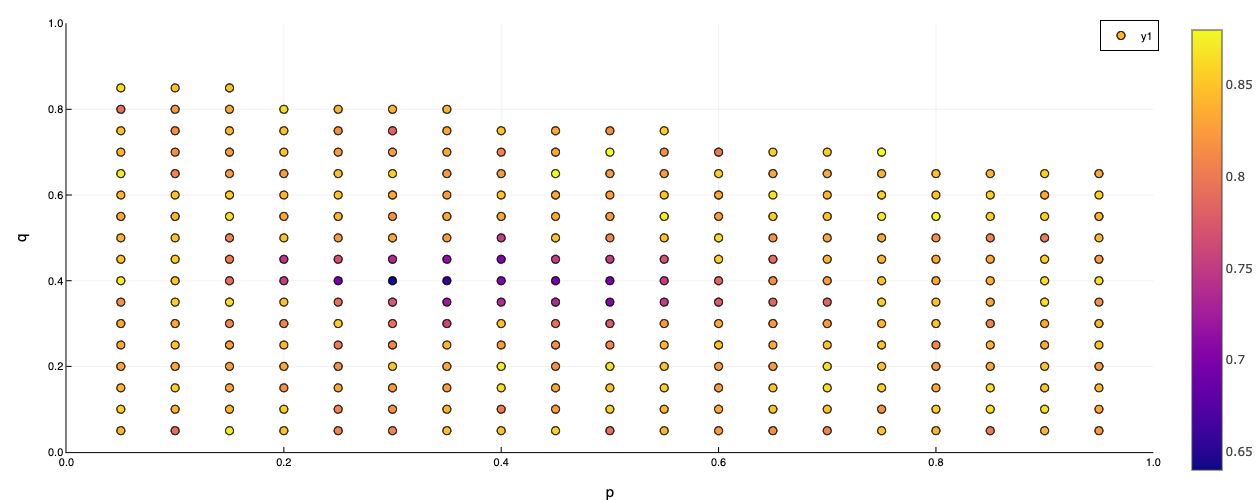

In [20]:
scatter(
    results_df.p,
    results_df.q,
    marker_z = results_df.block_match_ratio,
    markercolor = :plasma,
    xaxis = ("p", (0,1)),
    yaxis = ("q", (0,1)),
    size = (800, 500),
)

In [21]:
scatter(
    results_df.p,
    results_df.q,
    results_df.block_match_ratio,
    marker_z = results_df.block_match_ratio,
    markercolor = :plasma,
    xaxis = ("p", (0,1)),
    yaxis = ("q", (0,1)),
    zaxis = ("block match ratio"),
    size = (800, 500),
)

<!DOCTYPE html>
 
 
 Plots.jl

In [22]:
scatter(
    results_df.p,
    results_df.q,
    results_df.ρh,
    marker_z = results_df.block_match_ratio,
    markercolor = :plasma,
    xaxis = ("p", (0,1)),
    yaxis = ("q", (0,1)),
    zaxis = ("ρh"),
    size = (800, 500),
)

<!DOCTYPE html>
 
 
 Plots.jl

In [23]:
scatter(
    results_df.p,
    results_df.q,
    results_df.alignment_strength,
    marker_z = results_df.block_match_ratio,
    markercolor = :plasma,
    xaxis = ("p"),
    yaxis = ("q"),
    zaxis = ("alignment strength"),
    size = (800, 500),
)

<!DOCTYPE html>
 
 
 Plots.jl

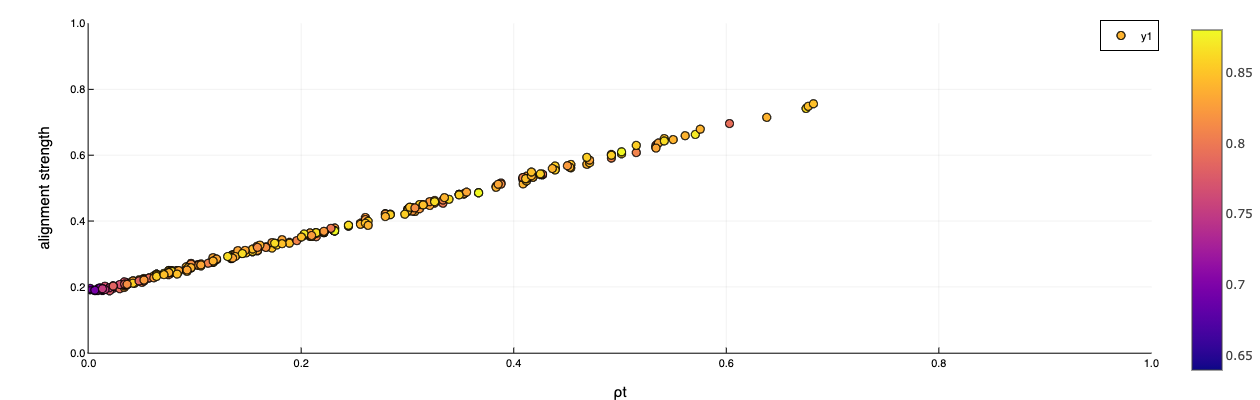

In [24]:
scatter(
    results_df.ρt,
    results_df.alignment_strength,
    marker_z = results_df.block_match_ratio,
    markercolor = :plasma,
    xaxis = ("ρt", (0,1)),
    yaxis = ("alignment strength", (0,1)),
)

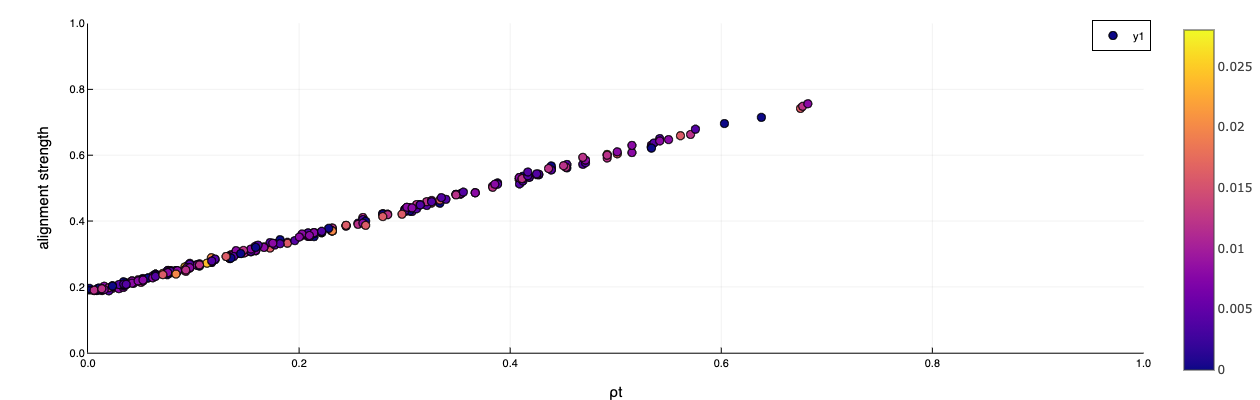

In [25]:
scatter(
    results_df.ρt,
    results_df.alignment_strength,
    marker_z = results_df.match_ratio,
    markercolor = :plasma,
    xaxis = ("ρt", (0,1)),
    yaxis = ("alignment strength", (0,1)),
)